# Feeder Data Statistical Analysis

This is severely limited by T&TEC's data. The exploration was guided by the approach taken by <a href="https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python">Banerjee</a> in analysing time-series.

# Setup

In [1]:
!pip install pandas_profiling

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization

mpl.rcParams['figure.dpi'] = 150

%matplotlib inline

In [3]:
df = pd.read_csv('../data/arganguez_feeder_data.csv')
df['Timestamp'] = pd.to_datetime(df.pop('Timestamp'))
df.set_index('Timestamp',inplace=True)
df.drop(['Times'],inplace=True,axis=1)
df.head()

,S total_SJN,P total_SJN,Q total_SJN,pf total_SJN
Timestamp,,,,
2016-02-25 08:45:00,12681.963,12242.791,3308.515,0.965
2016-02-25 08:30:00,12220.026,11800.326,3175.114,0.966
2016-02-25 08:15:00,12211.772,11787.791,3189.885,0.965
2016-02-25 08:00:00,11806.309,11435.935,2933.994,0.969
2016-02-25 07:45:00,11728.820,11377.988,2847.211,0.970


# Data Profiling

In [16]:
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Time Series Analysis

The below code analyzes the time-series for periodicity, trend and seasonality to determine if there is significant volatility as well as what trends are common so they can be used to develop representative feeder base loads. An investigation into the anomalies of the dataset is not done since the data appears clean at first glance.

## Behaviour over different intervals

The data is plotted over the course of the months and then weeks below.

In [5]:
def plot_df(df, y, title="", xlabel='Date', ylabel='Magnitude', dpi=150):
    plt.figure(figsize=(12,4), dpi=dpi)
    plt.plot(y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

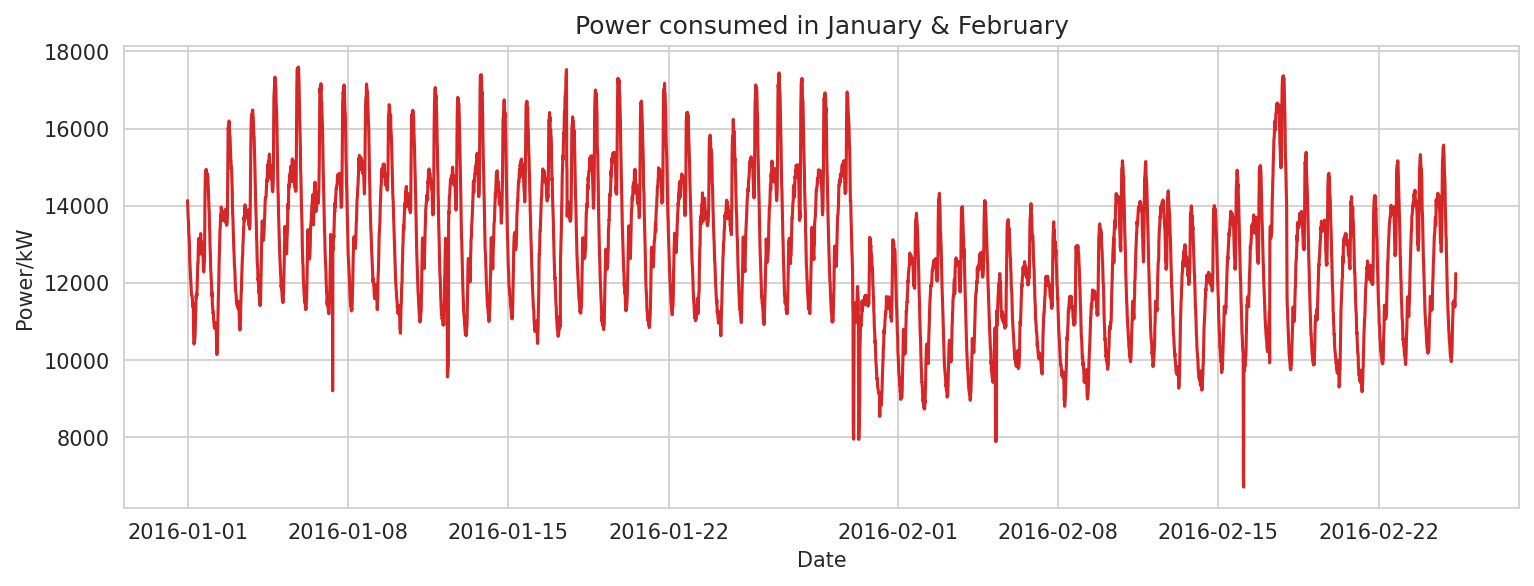

In [88]:
plot_df(df, y=df['P total_SJN'], title='Power consumed in January & February',ylabel='Power/kW')

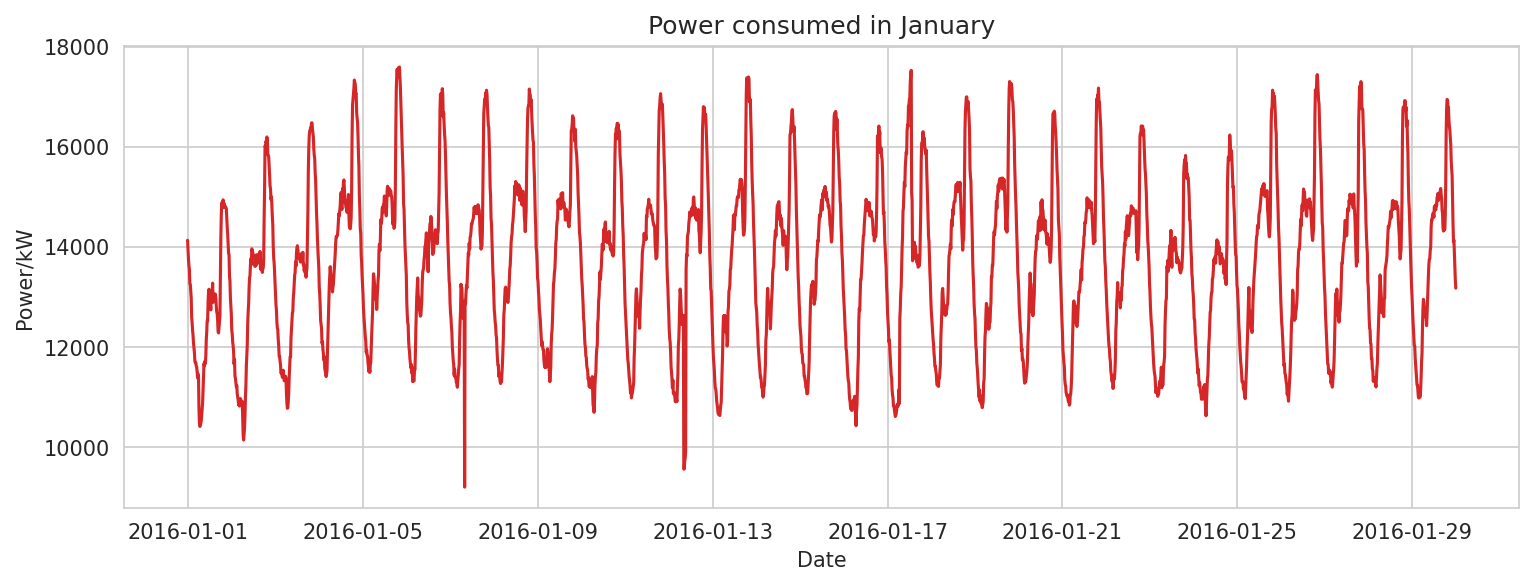

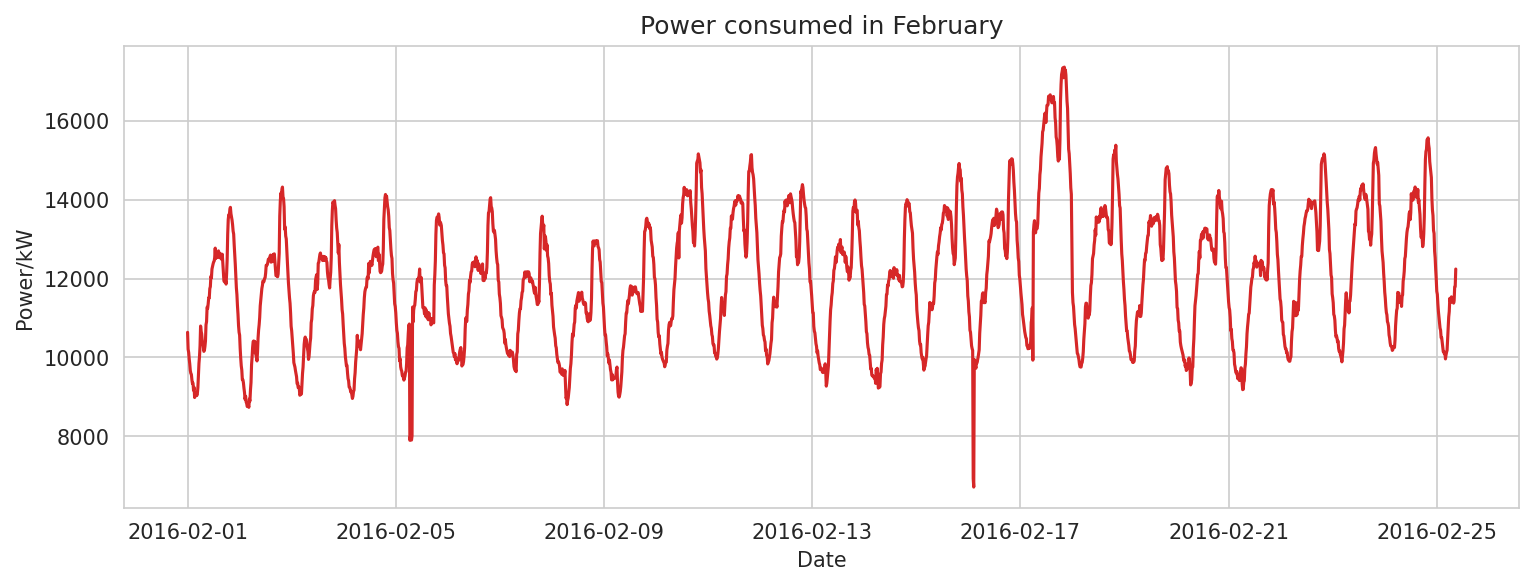

In [84]:
plot_df(df, y=df['P total_SJN']['2016-01-01':'2016-01-29'], title='Power consumed in January',ylabel='Power/kW')
plot_df(df, y=df['P total_SJN']['2016-02-01':], title='Power consumed in February',ylabel='Power/kW')

From the above, the data seems to have a noticeable drop transitioning from January to February. It appears that the data is cyclostationary or possibly seasonal in nature. However, further investigation is needed. It would be interesting to see how the data varies weekly as well.

<AxesSubplot:xlabel='Timestamp'>

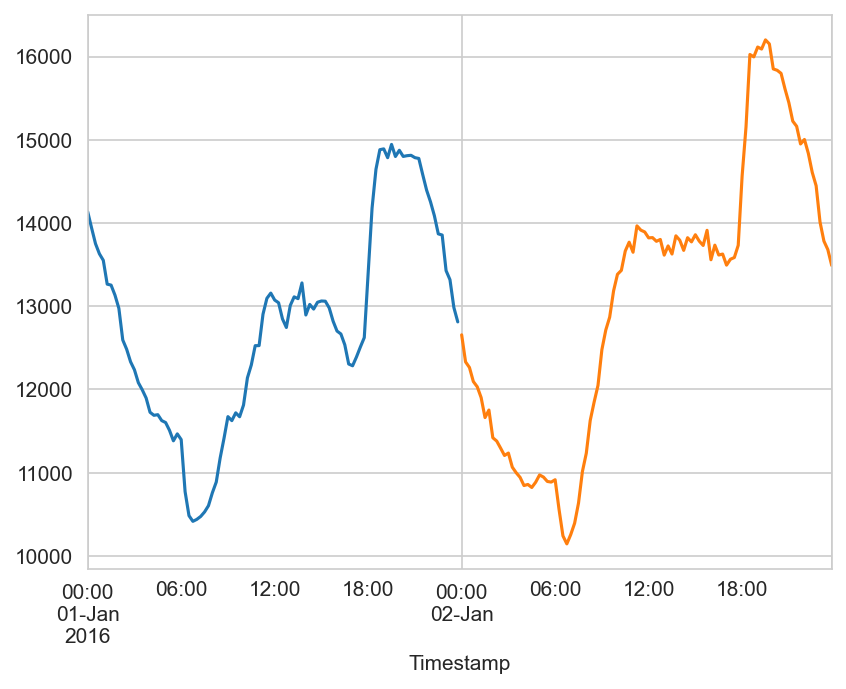

In [12]:
df['P total_SJN']['2016-01-01 00:00:00':'2016-01-01 23:45:00'].plot()
df['P total_SJN']['2016-01-02 00:00:00':'2016-01-02 23:45:00'].plot()

In [10]:
df['P total_SJN']['2016-01-01':'2016-01-02']

Timestamp
2016-01-02 23:45:00    13489.906
2016-01-02 23:30:00    13680.716
2016-01-02 23:15:00    13782.606
2016-01-02 23:00:00    14011.914
2016-01-02 22:45:00    14447.575
                         ...    
2016-01-01 01:00:00    13551.752
2016-01-01 00:45:00    13630.260
2016-01-01 00:30:00    13751.502
2016-01-01 00:15:00    13940.001
2016-01-01 00:00:00    14134.821
Name: P total_SJN, Length: 192, dtype: float64

# Unit Root Testing

To determine if the data is stationary, we first segment it into months and then weekly. Each segment is tested and visualized.

In [12]:
df_jan = df['2016-01-01':'2016-01-31']
df_feb = df['2016-02-01':]

## Weekly Stationarity

In [14]:
df_jan_wk1 = df_jan['2016-01-01':'2016-01-07']
df_jan_wk2 = df_jan['2016-01-08':'2016-01-14']
df_jan_wk3 = df_jan['2016-01-15':'2016-01-21']
df_jan_wk4 = df_jan['2016-01-22':'2016-01-29']

In [18]:
df_feb_wk1 = df['2016-01-30':'2016-02-05'] #this is due to the transition from Jan to Feb
df_feb_wk2 = df_feb['2016-02-06':'2016-02-12']
df_feb_wk3 = df_feb['2016-02-13':'2016-02-19']
df_feb_wk4 = df_feb['2016-02-20':'2016-02-26']

In [19]:
df_feb_wk1.tail()

,S total_SJN,P total_SJN,Q total_SJN,pf total_SJN
Timestamp,,,,
2016-01-30 01:00:00,11759.800,11390.617,2923.480,0.969
2016-01-30 00:45:00,12715.961,12308.572,3192.917,0.968
2016-01-30 00:30:00,12968.068,12547.708,3275.031,0.968
2016-01-30 00:15:00,13136.415,12724.683,3263.104,0.969
2016-01-30 00:00:00,13247.548,12843.784,3245.725,0.970


In [21]:
import statsmodels.tsa as tsa

In [49]:
#Testing whether the data is stationary with a daily lag.
jan_wk1_day_lg = tsa.stattools.adfuller(x=df_jan_wk1['P total_SJN'],maxlag=(24*4))
print(f'ADF Statistic: {jan_wk1_day_lg [0]}')
print(f'p-value: {jan_wk1_day_lg [1]}')
for key, value in jan_wk1_day_lg [4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.5190636697999476
p-value: 0.8882423552974661
Critial Values:
   1%, -3.4417738839904657
Critial Values:
   5%, -2.8665796253604015
Critial Values:
   10%, -2.569453974291115


The p-value is much greater than the significance level of 0.05 and hence we cannot reject the null hypothesis and thus the series is non-stationary.

In [25]:
#Testing whether the data is stationary using predefined lag
result = tsa.stattools.adfuller(x=df_jan_wk1['P total_SJN'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.4445578065513285
p-value: 0.0002473339206706742
Critial Values:
   1%, -3.4401772556197705
Critial Values:
   5%, -2.865876419242622
Critial Values:
   10%, -2.569079289056617


<AxesSubplot:xlabel='Timestamp'>

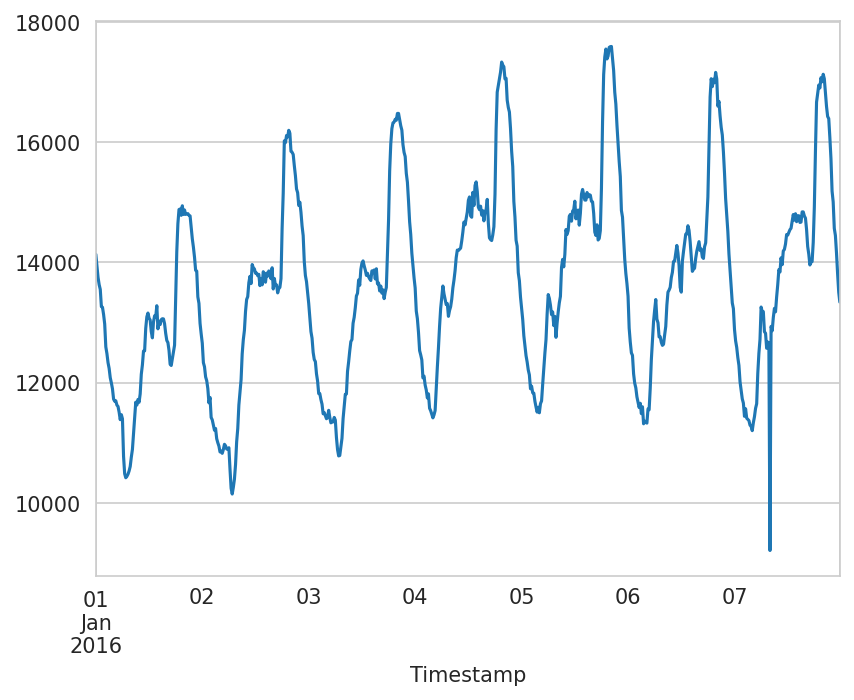

In [45]:
df_jan_wk1['P total_SJN'].plot(antialiased=True)

From the above analysis, we see that the series shows some periodicty and trend. From our preliminary unit root tests, it is shown it is not stationary at 24hr lags and hence each day's profile is differnt for the 1st week in Jan. This can be explored and quantified more later. Furthermore, time series decomoposition may assist in supporting our claims.

todo: Find a way to visualize results of stationarity tests elegantly

In [74]:
#testing stationarity with 96 samples lag
jan_wk2_day_lg =  tsa.stattools.adfuller(x=df_jan_wk2['P total_SJN'],maxlag=(24*4))
jan_wk3_day_lg =  tsa.stattools.adfuller(x=df_jan_wk3['P total_SJN'],maxlag=(24*4))
jan_wk4_day_lg =  tsa.stattools.adfuller(x=df_jan_wk4['P total_SJN'],maxlag=(24*4))

feb_wk1_day_lg =  tsa.stattools.adfuller(x=df_feb_wk1['P total_SJN'],maxlag=(24*4))
feb_wk2_day_lg =  tsa.stattools.adfuller(x=df_feb_wk2['P total_SJN'],maxlag=(24*4))
feb_wk3_day_lg =  tsa.stattools.adfuller(x=df_feb_wk3['P total_SJN'],maxlag=(24*4))
feb_wk4_day_lg =  tsa.stattools.adfuller(x=df_feb_wk4['P total_SJN'],maxlag=(24*4))


#testing stationarity with default samples lag
jan_wk1_default_lg =  tsa.stattools.adfuller(x=df_jan_wk1['P total_SJN'])
jan_wk2_default_lg =  tsa.stattools.adfuller(x=df_jan_wk2['P total_SJN'])
jan_wk3_default_lg =  tsa.stattools.adfuller(x=df_jan_wk3['P total_SJN'])
jan_wk4_default_lg =  tsa.stattools.adfuller(x=df_jan_wk4['P total_SJN'])

feb_wk1_default_lg =  tsa.stattools.adfuller(x=df_feb_wk1['P total_SJN'])
feb_wk2_default_lg =  tsa.stattools.adfuller(x=df_feb_wk2['P total_SJN'])
feb_wk3_default_lg =  tsa.stattools.adfuller(x=df_feb_wk3['P total_SJN'])
feb_wk4_default_lg =  tsa.stattools.adfuller(x=df_feb_wk4['P total_SJN'])


unit_root_day_lg_res = {'Jan Week 1':jan_wk1_day_lg,
                        'Jan Week 2':jan_wk2_day_lg,
                        'Jan Week 3':jan_wk3_day_lg,
                        'Jan Week 4':jan_wk4_day_lg,
                        'Feb Week 1':feb_wk1_day_lg,
                        'Feb Week 2':feb_wk2_day_lg,
                        'Feb Week 3':feb_wk3_day_lg,
                        'Feb Week 4':feb_wk4_day_lg}

unit_root_default_lg_res = {'Jan Week 1':jan_wk1_default_lg,
                            'Jan Week 2':jan_wk2_default_lg,
                            'Jan Week 3':jan_wk3_default_lg,
                            'Jan Week 4':jan_wk4_default_lg,
                            'Feb Week 1':feb_wk1_default_lg,
                            'Feb Week 2':feb_wk2_default_lg,
                            'Feb Week 3':feb_wk3_default_lg,
                            'Feb Week 4':feb_wk4_default_lg}

The above could probably be simplified by building a dashboard and allowing the user to input lags, and autolag methods.

In [75]:
df_uroot_day_lg = pd.DataFrame(unit_root_day_lg_res).transpose()
df_uroot_day_lg.rename(columns={0:'ADF Statistic',1:'p-value',2:'Lags Used',3:'Number of Observations',4:'Confidence Interval Results',5:'IC Results'},inplace=True)
df_uroot_day_lg['1% CI Value'] = df_uroot_day_lg['Confidence Interval Results'].apply(lambda x:x['1%'])
df_uroot_day_lg['5% CI Value'] = df_uroot_day_lg['Confidence Interval Results'].apply(lambda x:x['5%'])
df_uroot_day_lg['10% CI Value'] = df_uroot_day_lg['Confidence Interval Results'].apply(lambda x:x['10%'])
df_uroot_day_lg.drop('Confidence Interval Results',axis=1,inplace=True)

df_uroot_default_lg = pd.DataFrame(unit_root_default_lg_res).transpose()
df_uroot_default_lg.rename(columns={0:'ADF Statistic',1:'p-value',2:'Lags Used',3:'Number of Observations',4:'Confidence Interval Results',5:'IC Results'},inplace=True)
df_uroot_default_lg['1% CI Value'] = df_uroot_default_lg['Confidence Interval Results'].apply(lambda x:x['1%'])
df_uroot_default_lg['5% CI Value'] = df_uroot_default_lg['Confidence Interval Results'].apply(lambda x:x['5%'])
df_uroot_default_lg['10% CI Value'] = df_uroot_default_lg['Confidence Interval Results'].apply(lambda x:x['10%'])
df_uroot_default_lg.drop('Confidence Interval Results',axis=1,inplace=True)

In [76]:
df_uroot_day_lg

,ADF Statistic,p-value,Lags Used,Number of Observations,IC Results,1% CI Value,5% CI Value,10% CI Value
Jan Week 1,-0.519064,0.888242,96,575,7518.194996,-3.441774,-2.866580,-2.569454
Jan Week 2,-4.884412,0.000037,7,664,8063.68151,-3.440237,-2.865903,-2.569093
Jan Week 3,-2.567944,0.099805,96,575,7888.913723,-3.441774,-2.866580,-2.569454
Jan Week 4,-1.047319,0.735617,96,670,8797.524108,-3.440148,-2.865863,-2.569072
Feb Week 1,-1.287749,0.634758,96,575,7935.500759,-3.441774,-2.866580,-2.569454
Feb Week 2,-1.459076,0.55365,96,575,7325.205891,-3.441774,-2.866580,-2.569454
Feb Week 3,-4.06728,0.001096,5,666,8244.352804,-3.440207,-2.865889,-2.569086
Feb Week 4,-0.936903,0.775577,96,419,5391.394135,-3.446054,-2.868463,-2.570458


In [77]:
df_uroot_default_lg

,ADF Statistic,p-value,Lags Used,Number of Observations,IC Results,1% CI Value,5% CI Value,10% CI Value
Jan Week 1,-4.444558,0.000247,3,668,9197.968426,-3.440177,-2.865876,-2.569079
Jan Week 2,-4.884412,0.000037,7,664,9092.881216,-3.440237,-2.865903,-2.569093
Jan Week 3,-4.699714,0.000084,2,669,8907.176678,-3.440163,-2.865870,-2.569076
Jan Week 4,-5.517119,0.000002,9,757,9998.735666,-3.439018,-2.865366,-2.568807
Feb Week 1,-4.35081,0.000362,7,664,9313.986626,-3.440237,-2.865903,-2.569093
Feb Week 2,-4.347782,0.000367,3,668,8471.714544,-3.440177,-2.865876,-2.569079
Feb Week 3,-4.06728,0.001096,5,666,9278.134803,-3.440207,-2.865889,-2.569086
Feb Week 4,-4.254279,0.000533,4,511,6509.709726,-3.443212,-2.867213,-2.569791


## Monthly Stationarity

In [78]:
jan_daily_lg =  tsa.stattools.adfuller(x=df_jan['P total_SJN'],maxlag=(24*4))
feb_daily_lg =  tsa.stattools.adfuller(x=df_feb['P total_SJN'],maxlag=(24*4))

jan_default_lg =  tsa.stattools.adfuller(x=df_jan['P total_SJN'])
feb_default_lg =  tsa.stattools.adfuller(x=df_feb['P total_SJN'])


unit_root_mthly_lg_res = {'Jan Daily Lag':jan_daily_lg,
                            'Feb Daily Lag':feb_daily_lg,
                            'Jan Default Lag':jan_default_lg,
                            'Feb Default Lag':feb_default_lg,}


df_uroot_mthly_lg = pd.DataFrame(unit_root_mthly_lg_res).transpose()
df_uroot_mthly_lg.rename(columns={0:'ADF Statistic',1:'p-value',2:'Lags Used',3:'Number of Observations',4:'Confidence Interval Results',5:'IC Results'},inplace=True)
df_uroot_mthly_lg['1% CI Value'] = df_uroot_mthly_lg['Confidence Interval Results'].apply(lambda x:x['1%'])
df_uroot_mthly_lg['5% CI Value'] = df_uroot_mthly_lg['Confidence Interval Results'].apply(lambda x:x['5%'])
df_uroot_mthly_lg['10% CI Value'] = df_uroot_mthly_lg['Confidence Interval Results'].apply(lambda x:x['10%'])
df_uroot_mthly_lg.drop('Confidence Interval Results',axis=1,inplace=True)

In [79]:
df_uroot_mthly_lg

,ADF Statistic,p-value,Lags Used,Number of Observations,IC Results,1% CI Value,5% CI Value,10% CI Value
Jan Daily Lag,-4.476293,0.000217,96,2878,39644.020645,-3.432624,-2.862545,-2.567305
Feb Daily Lag,-1.991636,0.290252,96,2243,30448.284822,-3.433269,-2.862829,-2.567456
Jan Default Lag,-10.044726,0.0,12,2962,41047.617425,-3.432560,-2.862516,-2.567290
Feb Default Lag,-8.781113,0.0,13,2326,31783.227944,-3.433165,-2.862783,-2.567432


For small lags, the series is stationary and this can be used fore characterizing the time-series. I am not sure how, but there must exist a way to describe the shape of the time-series using the assumption of stationarity. Possibly, the mean over the lags, albeit the lags are very small.